# Generating Reaction Library Compounds

> Generating Reaction Library Compounds

- toc: true 
- badges: true
- comments: true
- categories: [RDKit, Reaction Library]

In [3]:
#collapse-hide
from io import BytesIO
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdRGroupDecomposition

from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

DrawingOptions.bondLineWidth=1.8
IPythonConsole.ipython_useSVG=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
import rdkit
print(rdkit.__version__)

2021.09.2


# Motivation

Modern compound library size is increasing fast thanks to parallel synthesis. Enamine REAL Space now have more than 10 billion compounds available for purchase and other vendors are also offering libraries that are much larger than traditional screening library size. 

The papers ([1](https://doi.org/10.1016/j.isci.2020.101681) and [2](https://pubmed.ncbi.nlm.nih.gov/34912117/)) from Enamine scientists discusses how they have constructed such library in detail. I got interested in building such library myself and tested if I can use RDKit to attempt such library 

# Synthons

Prepare a three groups; core, block1, and block2. For this particular blocks, they all have carboxyl group. The core has one tertiary amine, which can be reacted first, and N-Boc group, which can be deprotected and reacted in a second step.

Because the reaction order can be swapped, this three synthons will result in four different arrangement of functional group depending on the order of reaction:

- deacylation of group1, deprotection, deacylation of group1
- deacylation of group1, deprotection, deacylation of group2
- deacylation of group2, deprotection, deacylation of group1
- deacylation of group2, deprotection, deacylation of group2

Below is a core molecule, which have two tertiary amines and one of the amines is protected by Boc group, and two reactant groups, each having one carboxylate group, which can be acylated and readily reacted with a tertiary amine.

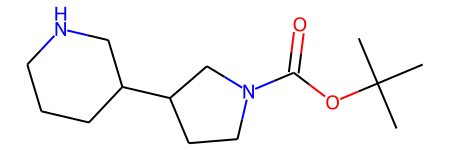

In [8]:
# core
core_smiles = 'C2CCNCC2C1CN(C(=O)OC(C)(C)(C))CC1'
core = Chem.MolFromSmiles(core_smiles)
core

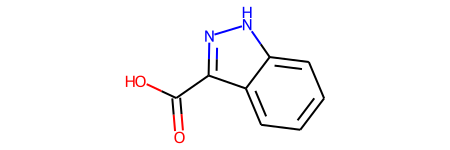

In [9]:
# block1
group1_smiles = 'c12ccccc1NN=C2(C(=O)O)'
group1 = Chem.MolFromSmiles(group1_smiles)
group1

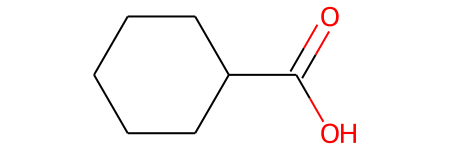

In [10]:
# block2
group2_smiles = 'C1CCCCC1C(=O)O'
group2 = Chem.MolFromSmiles(group2_smiles)
group2

# Reaction

Three main reaction are used here: acylation, amide formation, and deprotection. These reactions can be represented as below SMARTS strings. And I'll walk through different how we carry out reactions to generate new compound.

In [11]:
rxn_acylation_smarts = '[C;D3:1](=O)[O;D1:2]>>[C:1](=O)[*]'
rxn_acylamine_smarts = '[*:1][C:2](=O)[*;D1:3].[ND2:4]([*:5])([*:6])>>[N:4]([*:5])([*:6])([C:2](=O)[*:1])'
rxn_deprotection_smarts = '[N:1]C(=O)OC(C)(C)(C)>>[N:1]'

## Acylation of block 1

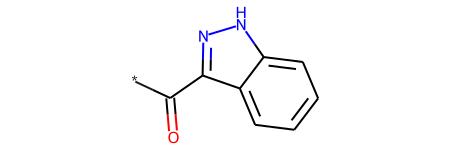

In [12]:
rxn = AllChem.ReactionFromSmarts(rxn_acylation_smarts)
group1_product = rxn.RunReactants((group1,))[0][0]
group1_product

## Block1 + Core = Product1

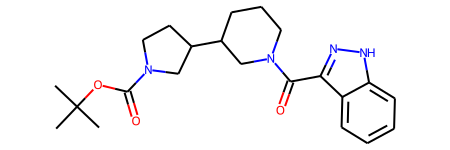

In [13]:
rxn = AllChem.ReactionFromSmarts(rxn_acylamine_smarts)
product1 = rxn.RunReactants((group1_product,core))[0][0]
product1

## Deprotection of Product 1

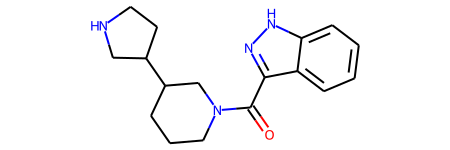

In [14]:
rxn = AllChem.ReactionFromSmarts(rxn_deprotection_smarts)
product2 = rxn.RunReactants((product1,))[0][0]
product2

## Acylation of Block 2

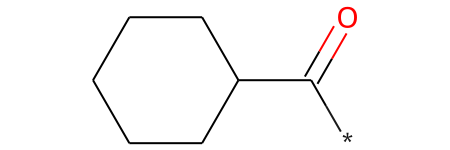

In [15]:
rxn = AllChem.ReactionFromSmarts(rxn_acylation_smarts)
group2_product = rxn.RunReactants((group2,))[0][0]
group2_product

## Block 2 + Product 2 = Final Product

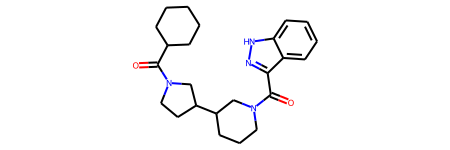

In [17]:
rxn = AllChem.ReactionFromSmarts(rxn_acylamine_smarts)
final_product = rxn.RunReactants((group2_product,product2))[0][0]
final_product

# Library Generation

We can easily scale up above procedure to generate a library of compounds by combinatorially using different reaction groups

In [18]:
core_smiles_arr = [core_smiles]
block_smiles_arr = [group1_smiles, group2_smiles]
  
# turn smiles to mol object
core_arr = [Chem.MolFromSmiles(smiles) for smiles in core_smiles_arr]
block_arr = [Chem.MolFromSmiles(smiles) for smiles in block_smiles_arr]

# set names for image generation
for i, core in enumerate(core_arr):
    core.SetProp("_Name", f'Core{i+1}')
for i, block in enumerate(block_arr):
    block.SetProp("_Name", f'Block{i+1}')

In [19]:
from itertools import product

product_library = []

def reaction(core, group1, group2):
    rxn = AllChem.ReactionFromSmarts(rxn_acylation_smarts)
    group1_product = rxn.RunReactants((group1,))[0][0]
    
    rxn = AllChem.ReactionFromSmarts(rxn_acylamine_smarts)
    product1 = rxn.RunReactants((group1_product,core))[0][0]
    
    rxn = AllChem.ReactionFromSmarts(rxn_deprotection_smarts)
    product2 = rxn.RunReactants((product1,))[0][0]
    
    rxn = AllChem.ReactionFromSmarts(rxn_acylation_smarts)
    group2_product = rxn.RunReactants((group2,))[0][0]
    
    rxn = AllChem.ReactionFromSmarts(rxn_acylamine_smarts)
    product = rxn.RunReactants((group2_product,product2))[0][0]
    return product


for core in core_arr:
    for block1, block2 in product(block_arr, repeat=2):
        compound = reaction(core, block1, block2)
        compound.SetProp('_Name', f'{block1.GetProp("_Name")}-{core.GetProp("_Name")}-{block2.GetProp("_Name")}')
        product_library.append(compound)

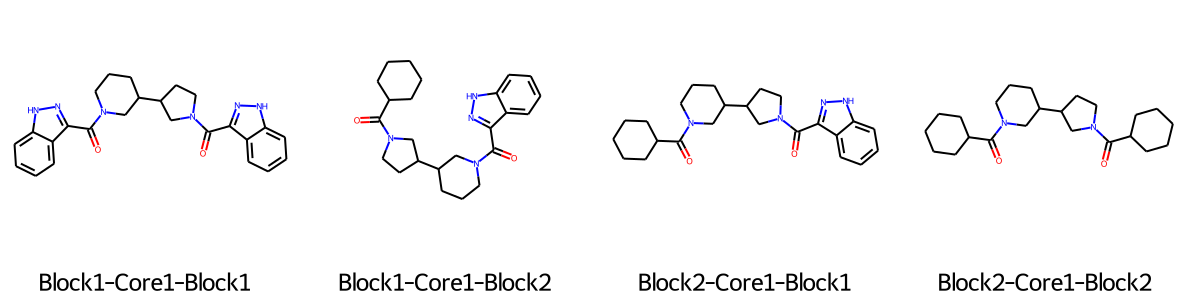

In [21]:
#collapse-hide
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO

ms = [Chem.RemoveHs(m) for m in product_library]
for m in ms: tmp=AllChem.Compute2DCoords(m)
legends=["%s" % (x.GetProp("_Name"), ) for i, x in enumerate(ms)]

molsPerRow = 4
subImgSize = (300, 300)
width = subImgSize[0] * molsPerRow
height = subImgSize[1] * int(len(ms) / molsPerRow)
d2d = rdMolDraw2D.MolDraw2DCairo(width, height, subImgSize[0], subImgSize[1])
d2d.drawOptions().legendFontSize=24

d2d.DrawMolecules(ms,legends=legends)
d2d.FinishDrawing()
img = BytesIO()
img.write(d2d.GetDrawingText())

from PIL import Image
Image.open(img)

# Conclusion

The actual code for building library was straightforward, as long as the fragments and the reactions are well curated, but I can imagine maintaining such curated fragment/reaction library at scale will be certainly a challenge. 

Also, if one attempts to build the entire possible library, the amount of computation will grow exponentially. For example, if we have 300 functional group blocks and 200 core blocks, which permits two reactions, the number of possible combinations are two billion already.

![feature](files/two_billion_meme.jpg)

The [paper](https://pubmed.ncbi.nlm.nih.gov/34912117/) also illustrates how such database can be constructed on-the-fly with clever use of virtual screening method, alleviate the need to store the entire library on disk and reduce computation significantly. 